<a href="https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/sign_detector_augmentated_v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/sign_detector.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

In [344]:
colab = False

if colab == True:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install kaggle
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
    !kaggle datasets download watchman/rtsd-dataset
    !unzip rtsd-dataset.zip
    !rm rtsd-dataset.zip
    !cp -r rtsd-frames/rtsd-frames/ .
    !rm -r rtsd-frames/rtsd-frames/
    !pip install fiftyone
if colab == True:
    dataset_path = '.'
    checkpoints_path = '../content/drive/MyDrive/TSR/checkpoints'
else:
    dataset_path = 'data'
    checkpoints_path = 'checkpoints'

In [343]:
import os
import json
import numpy as np 
import pandas as pd 

from PIL import Image
import matplotlib.pyplot as plt
#import matplotlib.patches as patches
#%matplotlib inline

#from pycocotools.coco import COCO
#import fiftyone as fo
import time
import torch
import torch.nn as nn
#import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
#from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.models.detection import FasterRCNN
from torchvision.models import resnet152
#import cv2
#PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0

## Обучение модели

### Загрузчик данных

In [345]:
class RTSD_dataset_classifier(Dataset):
    def __init__(self, json_path, img_path, transforms):
        self.json_path = json_path
        self.img_path = img_path
        self.transforms = transforms
        
        with open(json_path, 'r') as read_file:
            self.anno = json.load(read_file)
        read_file.close()

        self.df_anno = pd.DataFrame(self.anno.get('annotations'))[['image_id','bbox','category_id']]
        self.df_images = pd.DataFrame(self.anno.get('images'))[['id','file_name']]
        self.df_dataset = self.df_anno.merge(self.df_images, left_on='image_id', right_on='id',)[['file_name','bbox','category_id']]
        #self.labels = torch.eye(156)[self.df_dataset['category_id']]
    def __len__(self):
        return self.df_dataset.shape[0]

    def __getitem__(self, index):
        img_name = self.df_dataset.loc[index,'file_name']
        bbox = self.df_dataset.loc[index,'bbox']
        bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
        img = Image.open(os.path.join(self.img_path, img_name))
        img = img.crop(bbox)
        img = self.transforms(img)
        label = torch.tensor(self.df_dataset.loc[index,'category_id'] - 1)
        
        return {'images':img, 'labels':label}



In [346]:
def get_transform(train):
    if train == True:
        return transforms.Compose([transforms.Resize((224,224)),
                                   transforms.ToTensor(),
                                   #transforms.Normalize([0.496, 0.456, 0.406],
                                   #                     [0.229, 0.224, 0.225])
                                   ])
    else:
        return transforms.Compose([transforms.Resize((224,224)),
                                   transforms.ToTensor(),
                                   #transforms.Normalize([0.496, 0.456, 0.406],
                                   #                     [0.229, 0.224, 0.225])
                                   ])

In [347]:
test = RTSD_dataset_classifier(json_path = os.path.join(dataset_path, 'train_anno_reduced.json'),
                               img_path = dataset_path,
                               transforms = get_transform(train=True)
                               )

In [348]:
test.__getitem__(2324)

{'images': tensor([[[0.2627, 0.2627, 0.2627,  ..., 0.4745, 0.4745, 0.4745],
          [0.2627, 0.2627, 0.2627,  ..., 0.4745, 0.4745, 0.4745],
          [0.2627, 0.2627, 0.2627,  ..., 0.4745, 0.4745, 0.4745],
          ...,
          [0.1608, 0.1608, 0.1608,  ..., 0.3804, 0.3804, 0.3804],
          [0.1608, 0.1608, 0.1608,  ..., 0.3765, 0.3765, 0.3765],
          [0.1608, 0.1608, 0.1608,  ..., 0.3765, 0.3765, 0.3765]],
 
         [[0.2627, 0.2627, 0.2627,  ..., 0.5098, 0.5098, 0.5098],
          [0.2627, 0.2627, 0.2627,  ..., 0.5098, 0.5098, 0.5098],
          [0.2627, 0.2627, 0.2627,  ..., 0.5098, 0.5098, 0.5098],
          ...,
          [0.1608, 0.1608, 0.1608,  ..., 0.3882, 0.3882, 0.3882],
          [0.1608, 0.1608, 0.1608,  ..., 0.3843, 0.3843, 0.3843],
          [0.1608, 0.1608, 0.1608,  ..., 0.3843, 0.3843, 0.3843]],
 
         [[0.2627, 0.2627, 0.2627,  ..., 0.4980, 0.4980, 0.4980],
          [0.2627, 0.2627, 0.2627,  ..., 0.4980, 0.4980, 0.4980],
          [0.2627, 0.2627, 0.2

0

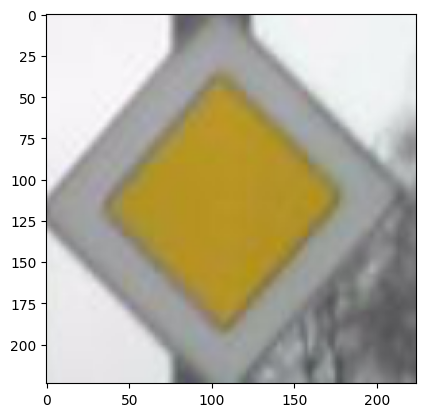

In [349]:
def plot_sign(index):
    item = test.__getitem__(index)
    img = item['images']
    target = item['labels']
    #img, target = test.__getitem__(index)
    img = img.permute(1, 2, 0).detach().numpy()
    img = img*255
    img = img.astype(np.uint8)
    fig, a = plt.subplots(1,1)
    #fig.set_size_inches(10,10)
    display(int(target.cpu().detach().numpy()))
    a.imshow(img)
    return None
plot_sign(2)

### Формирование батча

In [282]:
'''def collate_fn_conv(data: list):
  # data = [(pic, target)...]
  pics = []
  target = []
  for item in data:
    pics.append(np.array(item[0]))
    target.append(item[1])
  pics = torch.from_numpy(np.array(pics)).float() #/ 255 # B x W x H
  target = torch.from_numpy(np.array(target))

  return {
      # метод unsqueeze добавляет метод измерения в тензоре
      # сверточный слой ждет число каналов (изображения подаются поканально)
      'data': pics, # B x 1 x W x H
      'target': target.long(),
      }'''

In [ ]:
'''data_list = []
for i in range(8):
    data_list.append(test.__getitem__(i))
data_list'''

In [186]:
#collate_fn_conv(data_list).get('data').shape, collate_fn_conv(data_list).get('target').shape

torch.Size([8, 3, 224, 224])

In [191]:
'''def collate_fn(batch):
    return tuple(zip(*batch))'''

### Гиперпараметры

In [440]:
device_id = 0
if torch.cuda.is_available() == True:
    device = f'cuda:{device_id}'
elif torch.backends.mps.is_available() == True:
    device = 'mps'
else:
    device = 'cpu'
n_epochs = 1
batch_size = 128
num_classes = 155

In [394]:
device

'mps'

### Инициализация модели, задание оптимизатора и функции потерь

In [441]:
def create_model(num_classes):
    model = resnet152(weights='ResNet152_Weights.IMAGENET1K_V1')
    for param in model.parameters():
        param.requires_grad = False
    
    model.fc = nn.Sequential(nn.Linear(2048, 1024), nn.Linear(1024, num_classes))
    for param in model.fc.parameters():
        param.requires_grad = True

    #torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.COCO_V1')
    #in_features = model.roi_heads.box_predictor.cls_score.in_features
    #model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [442]:
model = create_model(num_classes).to(device)

loss_function = nn.CrossEntropyLoss()

# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
#params = [p for p in model.parameters() if p.requires_grad]

#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)



#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
train_dataset = RTSD_dataset_classifier(#json_path = os.path.join(dataset_path, 'train_anno_reduced.json'),
                                        json_path = os.path.join(dataset_path, 'train_anno.json'),
                                        img_path = dataset_path,
                                        transforms = get_transform(train=True)
                                        )
val_dataset = RTSD_dataset_classifier(os.path.join(dataset_path, 'val_anno.json'),
                                        dataset_path,
                                          transforms = get_transform(train=False)
                                          )

train_data_loader = DataLoader(
    train_dataset,
    #sampler=SubsetRandomSampler(),
    batch_size=batch_size,
    shuffle=True,
    #num_workers=4,
    #collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    #sampler=SubsetRandomSampler(),
    batch_size=batch_size,
    shuffle=False,
    #num_workers=4,
    #collate_fn=collate_fn
)

### Трейн луп

In [330]:
for batch_idx, data in enumerate(train_data_loader):
    a = data
    break

In [239]:
a['labels']

tensor([[ 55],
        [  3],
        [115],
        [ 46],
        [124],
        [ 49],
        [ 35],
        [111],
        [147],
        [ 57],
        [138],
        [109],
        [ 99],
        [ 79],
        [146],
        [ 71]])

In [443]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)

    training_loss=0
    correct = 0.0
    total = 0.0

    model.train()
    running_loss = 0        # training_loss
    for batch_idx, data in enumerate(train_dataloader):
        
        
        
        optimizer.zero_grad()
        #images, targets = data[0], data[1]
        #images = images.to(device)
        #targets = targets.to(device)
        images = data['images'].to(device)
        targets = data['labels'].to(device)
        output = model(images)
        loss = loss_function(output, targets)
        loss.backward()
        optimizer.step()
        
        running_loss = running_loss + ((1/(batch_idx+1))*(loss.data-running_loss))
        if batch_idx%20 == 0:
            print(f"Batch Id {batch_idx} is having training loss of {running_loss}")
            print(loss.item())

        pred = output.data.max(1,keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
        print(f"Accuracy on batch {batch_idx} on Training is {(100*correct/total)}")


        #images = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #loss_dict = model(images, targets)
        #loss = sum(loss for loss in loss_dict.values())
        #running_loss += loss.item()
        #loss.backward()
        #optimizer.step()
        #if batch_idx % 50 == 0:
        #    print(f"\tЭпоха {epoch}. Итерация {batch_idx}/{len_dataloader}. Loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

In [444]:
def val (val_dataloader, epoch):
    #len_dataloader = len(train_dataloader)

    validation_loss=0
    correct = 0.0
    total = 0.0

    model.eval()

    for batch_idx, data in enumerate(val_dataloader):
        
        
        optimizer.zero_grad()
        #images, targets = data[0], data[1]
        #images = images.to(device)
        #targets = targets.to(device)
        images = data['images'].to(device)
        targets = data['labels'].to(device)
        #with torch.no_grad():
            
        output = model(images)
        loss = loss_function(output, targets)
        
        validation_loss = validation_loss + ((1/(batch_idx+1))*(loss.data-validation_loss))
        #if batch_idx%20 == 0:
        print(f"Batch Id {batch_idx} is having validation loss of {validation_loss}")
        print(loss.item())

        pred = output.data.max(1,keepdim=True)[1]
        correct += np.sum(np.squeeze(pred.eq(targets.data.view_as(pred))).cpu().numpy())
        total += images.size(0)
        print(f"Batch Id {batch_idx} is having validation accuracy of {(100*correct/total)}")


        #images = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #loss_dict = model(images, targets)
        #loss = sum(loss for loss in loss_dict.values())
        #running_loss += loss.item()
        #loss.backward()
        #optimizer.step()
        #if batch_idx % 50 == 0:
        #    print(f"\tЭпоха {epoch}. Итерация {batch_idx}/{len_dataloader}. Loss: {loss}")
    val_loss = validation_loss/len(val_dataloader.dataset)
    return val_loss

In [435]:
val_loss = val(val_data_loader, epoch)

Batch Id 0 is having validation loss of 1.296499252319336
1.296499252319336
Batch Id 0 is having validation accuracy of 71.09375
Batch Id 1 is having validation loss of 1.2819761037826538
1.2674529552459717
Batch Id 1 is having validation accuracy of 71.2890625
Batch Id 2 is having validation loss of 1.2581762075424194
1.2105765342712402
Batch Id 2 is having validation accuracy of 72.39583333333333
Batch Id 3 is having validation loss of 1.2850885391235352
1.3658254146575928
Batch Id 3 is having validation accuracy of 72.75390625
Batch Id 4 is having validation loss of 1.2945460081100464
1.3323757648468018
Batch Id 4 is having validation accuracy of 72.265625
Batch Id 5 is having validation loss of 1.279439091682434
1.203904628753662
Batch Id 5 is having validation accuracy of 72.265625
Batch Id 6 is having validation loss of 1.281502604484558
1.2938835620880127
Batch Id 6 is having validation accuracy of 71.98660714285714
Batch Id 7 is having validation loss of 1.2708760499954224
1.19

In [421]:
train_loss

tensor(1.9641e-05, device='mps:0')

In [438]:
1.195412516593933/len(val_data_loader.dataset)

0.00013483109819466876

In [437]:
len(val_data_loader.dataset)

8866

In [436]:
val_loss

tensor(0.0001, device='mps:0')

In [445]:
train_losses = []
val_losses = []
try:
    for epoch in range(n_epochs):
        start = time.time()
        train_loss = train(train_data_loader, epoch)
        val_loss = val(val_data_loader, epoch)
        #val_loss = 0 # удалить потом
        #lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        '''torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'losses_train': train_losses,
            'losses_val': val_losses
            }, os.path.join(checkpoints_path, f'chkpt_{model_name}_{epoch}.pth'))
    
        torch.save(model, os.path.join(checkpoints_path, f'model_{model_name}_{epoch}.pth'))'''
    
except KeyboardInterrupt:
    print('Прервано пользователем')

Batch Id 0 is having training loss of 4.988743305206299
4.988743305206299
Accuracy on batch 0 on Training is 2.34375
Accuracy on batch 1 on Training is 4.6875
Accuracy on batch 2 on Training is 11.458333333333334
Accuracy on batch 3 on Training is 13.8671875
Accuracy on batch 4 on Training is 15.3125
Accuracy on batch 5 on Training is 16.666666666666668
Accuracy on batch 6 on Training is 17.857142857142858
Accuracy on batch 7 on Training is 17.87109375
Accuracy on batch 8 on Training is 17.79513888888889
Accuracy on batch 9 on Training is 20.0
Accuracy on batch 10 on Training is 19.389204545454547
Accuracy on batch 11 on Training is 18.75
Accuracy on batch 12 on Training is 18.509615384615383
Accuracy on batch 13 on Training is 19.029017857142858
Accuracy on batch 14 on Training is 19.895833333333332
Accuracy on batch 15 on Training is 20.1171875
Accuracy on batch 16 on Training is 20.68014705882353
Accuracy on batch 17 on Training is 20.833333333333332
Accuracy on batch 18 on Training

In [21]:
last_epoch = 2
# Загрузка весов модели
checkpoint = torch.load(os.path.join(checkpoints_path, f'model_detector_resnet50_augmented_{last_epoch}.pth'), map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
#epoch = checkpoint['epoch']
train_losses = checkpoint['losses_train']
val_losses = checkpoint['losses_val']

In [ ]:
if last_epoch == None:
    train_losses = []
    val_losses = []
else:
    # Загрузка весов модели
    checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_{model_name}_{last_epoch}.pth'), map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
    #epoch = checkpoint['epoch']
    train_losses = checkpoint['losses_train']
    val_losses = checkpoint['losses_val']

In [27]:
last_epoch = 3
model_name = 'detector_resnet50_augmented'


if last_epoch == None:
    train_losses = []
    val_losses = []
else:
    # Загрузка весов модели
    checkpoint = torch.load(os.path.join(checkpoints_path, f'chkpt_{model_name}_{last_epoch}.pth'), map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])
    #epoch = checkpoint['epoch']
    train_losses = checkpoint['losses_train']
    val_losses = checkpoint['losses_val']

In [24]:
model_name = 'detector_resnet50_augmented'

In [29]:
try:
    for epoch in range(last_epoch + 1, n_epochs):
        start = time.time()
        train_loss = train(train_data_loader, epoch)
        val_loss = val(val_data_loader, epoch)
        #lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'losses_train': train_losses,
            'losses_val': val_losses
            }, os.path.join(checkpoints_path, f'chkpt_{model_name}_{epoch}.pth'))
    
        torch.save(model, os.path.join(checkpoints_path, f'model_{model_name}_{epoch}.pth'))
    
except KeyboardInterrupt:
    print('Прервано пользователем')

	Эпоха 4. Итерация 0/3387. Loss: 0.11603625863790512
	Эпоха 4. Итерация 50/3387. Loss: 0.09132763743400574
	Эпоха 4. Итерация 100/3387. Loss: 0.09525351226329803
	Эпоха 4. Итерация 150/3387. Loss: 0.08201088011264801
	Эпоха 4. Итерация 200/3387. Loss: 0.11788337677717209
	Эпоха 4. Итерация 250/3387. Loss: 0.09946923702955246
	Эпоха 4. Итерация 300/3387. Loss: 0.09350793063640594
	Эпоха 4. Итерация 350/3387. Loss: 0.09657343477010727
	Эпоха 4. Итерация 400/3387. Loss: 0.08998836576938629
	Эпоха 4. Итерация 450/3387. Loss: 0.08942896872758865
	Эпоха 4. Итерация 500/3387. Loss: 0.0664619505405426
	Эпоха 4. Итерация 550/3387. Loss: 0.08274924755096436
	Эпоха 4. Итерация 600/3387. Loss: 0.06323593109846115
	Эпоха 4. Итерация 650/3387. Loss: 0.07226131856441498
	Эпоха 4. Итерация 700/3387. Loss: 0.07295990735292435
	Эпоха 4. Итерация 750/3387. Loss: 0.06773833930492401
	Эпоха 4. Итерация 800/3387. Loss: 0.11777892708778381
	Эпоха 4. Итерация 850/3387. Loss: 0.09019037336111069
	Эпоха 4. Итер

In [26]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'losses_train': train_losses,
            'losses_val': val_losses
            }, os.path.join(checkpoints_path, f'chkpt_{model_name}_{epoch}.pth'))
    
torch.save(model, os.path.join(checkpoints_path, f'model_{model_name}_{epoch}.pth'))

In [ ]:
checkpoints_path

'../checkpoints'

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'losses_train': train_losses,
            'losses_val': val_losses
            }, os.path.join(checkpoints_path, f'model_detector_resnet50_augmented_{epoch}.pth'))

In [ ]:
checkpoint2 = torch.load(os.path.join('checkpoints', f'model_detector_resnet50_augmented_2.pth'), map_location=device)


In [ ]:
checkpoint3 = torch.load(os.path.join('checkpoints', f'model_detector_resnet50_augmented_3.pth'), map_location=device)

In [ ]:
checkpoint2['losses_train']

[0.006822872471820277, 0.00596496530648258, 0.005799468892012618]

In [ ]:
checkpoint3['losses_train']

[0.006822872471820277,
 0.00596496530648258,
 0.005799468892012618,
 0.011846726517383244]

In [ ]:
train_losses, val_losses

([0.014400107387186303], [0.010745501028001309])

In [ ]:
'''torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'losses_train': train_losses,
    'losses_val': val_losses
    }, os.path.join(dataset_path, f'../checkpoints/model_detector_resnet50_augmented_{epoch}.pth'))'''

In [ ]:
def create_model(num_classes, pretrained=True):
    model =torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights='FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
model = create_model(num_classes=2, pretrained=True).to(device)




# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

#params = [p for p in model.parameters() if p.requires_grad]

#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)



#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
train_dataset = RTSD_dataset(os.path.join(dataset_path, 'train_anno_bin_class.json'),
                                          dataset_path)
val_dataset = RTSD_dataset(os.path.join(dataset_path, 'val_anno_bin_class.json'), dataset_path)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    #num_workers=4,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    #num_workers=4,
    collate_fn=collate_fn
)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to C:\Users\User/.cache\torch\hub\checkpoints\fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

In [ ]:
def train(train_dataloader, epoch): 
    len_dataloader = len(train_dataloader)
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print(f"\tЭпоха {epoch}. Итерация {i}/{len_dataloader}. Loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader, epoch):
    running_loss = 0
    for data in val_dataloader:
        optimizer.zero_grad()
        images, targets = data[0], data[1]
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            loss_dict = model(images, targets)
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss 

In [ ]:
train_losses = []
val_losses = []
try:
    for epoch in range(n_epochs):
        start = time.time()
        train_loss = train(train_data_loader, epoch)
        val_loss = val(val_data_loader, epoch)
        #lr_scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")  
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler.state_dict(),
            'losses_train': train_losses,
            'losses_val': val_losses
            }, os.path.join(dataset_path, f'../checkpoints/model_detector_resnet50_augmented_{epoch}.pth'))
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
    'losses_train': train_losses,
    'losses_val': val_losses
    }, os.path.join(dataset_path, f'../checkpoints/model_detector_resnet50_augmented_full.pth'))
except KeyboardInterrupt:
    print('Прервано пользователем')

	Эпоха 0. Итерация 0/6774. Loss: 0.8358988165855408
	Эпоха 0. Итерация 50/6774. Loss: 0.09858530014753342
	Эпоха 0. Итерация 100/6774. Loss: 0.2172754555940628
	Эпоха 0. Итерация 150/6774. Loss: 0.40015822649002075
	Эпоха 0. Итерация 200/6774. Loss: 0.13395972549915314
	Эпоха 0. Итерация 250/6774. Loss: 0.28839361667633057
	Эпоха 0. Итерация 300/6774. Loss: 0.2116183489561081
	Эпоха 0. Итерация 350/6774. Loss: 0.2833598256111145
	Эпоха 0. Итерация 400/6774. Loss: 0.2793215811252594
	Эпоха 0. Итерация 450/6774. Loss: 0.309714674949646
	Эпоха 0. Итерация 500/6774. Loss: 0.20718857645988464
	Эпоха 0. Итерация 550/6774. Loss: 0.26163995265960693
	Эпоха 0. Итерация 600/6774. Loss: 0.35022008419036865
	Эпоха 0. Итерация 650/6774. Loss: 0.25102320313453674
	Эпоха 0. Итерация 700/6774. Loss: 0.36677470803260803
	Эпоха 0. Итерация 750/6774. Loss: 0.34893864393234253
	Эпоха 0. Итерация 800/6774. Loss: 0.32514622807502747
	Эпоха 0. Итерация 850/6774. Loss: 0.2878253161907196
	Эпоха 0. Итерация 90

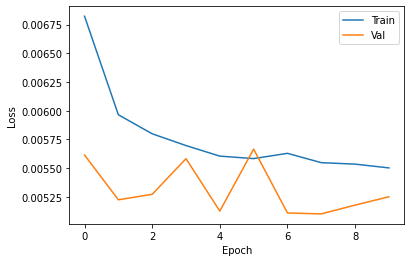

In [30]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(val_losses, label='Val')
#ax.plot(val_losses, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()
plt.show()